## Capture velocity optimization for CaF

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
from scipy.optimize import bisect #For root finding
import time

In [49]:
start = time.time()

Gamma = 8.3 # MHz
Gamma = 8.3 # MHz, Decay rate
k = 1/606*1e9*2*np.pi #x_0 with meter
x0 = 1/k
t0 = 1/(2*np.pi*Gamma*1e6)
v0 = x0/t0
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
m0=  cts.hbar*t0/x0**2
mass = 59*cts.value('atomic mass constant')/m0 # m_0

H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(
    N=1, Lambda=0, B=0, b=109.1893/Gamma, c=40.1190/Gamma,
    cc=2.876e-2/Gamma, gamma=39.65891/Gamma,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )
E_X = np.unique(np.diag(H0_X))
H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=2.4/Gamma, q=0, p=0, gJ=2*-0.021,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )
E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, I1=1/2, S=1/2, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass=mass)

omega = 2*np.pi*(cts.c/606e-9)
k = 1e-6/(606e-9) #MHz/(m/s)
Isat = cts.hbar*omega**3*(2*np.pi*Gamma*1e6)/(12*np.pi*cts.c**2)

# A litle helper function to make the MOT:
def six_beam_CaF_MOT(svec, detvec, polvec, waistvec):
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        laserBeams += pylcp.conventional3DMOTBeams(
            s=svec[ii], delta=(E_A[-1] - Eg_i)+detvec[ii], pol=polvec[ii], wb=waistvec[ii],
            beam_type=pylcp.gaussianBeam
            )
#         laserBeams += pylcp.conventional3DMOTBeams(
#             s=svec[ii], delta=(E_A[-1] - Eg_i)+detvec[ii], pol=polvec[ii],
#             beam_type=pylcp.infinitePlaneWaveBeam
#             )

    return laserBeams

In [50]:
omega = 2*np.pi*(cts.c/606e-9) #Transition frequency
Isat = cts.hbar*omega**3*(2*np.pi*Gamma*1e6)/(12*np.pi*cts.c**2)

# Make the magnetic field (2 G/mm):
magField = pylcp.quadrupoleMagneticField(2)

def six_beam_CaF_MOT(s, det):
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        if ii<3:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)+det, pol=+1,wb=12,
                beam_type=pylcp.gaussianBeam
                )
        else:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)+det, pol=-1,wb=12,
                beam_type=pylcp.gaussianBeam
                )

    return laserBeams

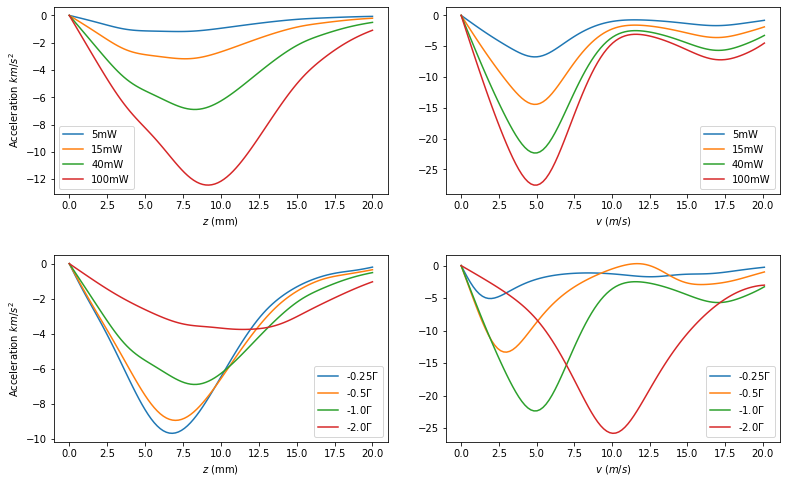

In [51]:
# The detunings used in the PRAs:
dets = np.array([-0.25, -0.5, -1, -2])
P = np.array([0.005, 0.015, 0.040, 0.1])
intensities = 2.*P/(np.pi*0.012**2)/Isat
# Make the axis:
z = np.linspace(0, 20., 101)
v = np.linspace(0., 4., 101)

# Start the figure:
fig, ax = plt.subplots(2, 2, figsize=(13, 8), num="Forces in CaF MOT")
for ii, intensity in enumerate(intensities):
    laserBeams = six_beam_CaF_MOT(intensity, dets[2])
    trap = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)
    trap.generate_force_profile(
        [np.zeros(z.shape), np.zeros(z.shape), z],
        [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
        name='Fz')
    trap.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), 1e-9*np.ones(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='Fv')
    ax[0, 0].plot(z, trap.profile['Fz'].F[2]/mass*a0*1e-3, color='C{0:d}'.format(ii),label = f'{int(1000*P[ii])}mW')
    ax[0, 1].plot(v*v0, trap.profile['Fv'].F[2]/mass*a0*1e-3, color='C{0:d}'.format(ii),label = f'{int(1000*P[ii])}mW')

for ii, det_i in enumerate(dets):
    laserBeams = six_beam_CaF_MOT(intensities[2], det_i)
    trap = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)
    trap.generate_force_profile(
        [np.zeros(z.shape), np.zeros(z.shape), z],
        [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
        name='Fz')
    trap.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), 1e-9*np.ones(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='Fv')
    ax[1, 0].plot(z,trap.profile['Fz'].F[2]/mass*a0*1e-3, color='C{0:d}'.format(ii),label = f'{det_i}$\Gamma$')
    ax[1, 1].plot(v*v0,trap.profile['Fv'].F[2]/mass*a0*1e-3, color='C{0:d}'.format(ii),label = f'{det_i}$\Gamma$')

ax[0, 0].set_ylabel('Acceleration $km/s^2$')
ax[1, 0].set_ylabel('Acceleration $km/s^2$')

for ax_i in ax[:, 0]:
    ax_i.set_xlabel('$z$ (mm)')
    ax_i.legend()
for ax_i in ax[:, 1]:
    ax_i.set_xlabel('$v\ (m/s)$')
    ax_i.legend()
fig.subplots_adjust(hspace=0.33, wspace=0.175)
# fig.savefig('tarbutt.png')

In [52]:
delta0 = dets[2]
int0 = intensities[2]
dz = 0.05
dv = 0.05
zz = np.linspace(-20,20+dz,100)
vv = np.linspace(-10,10+dv,100)
Z,V = np.meshgrid(zz,vv)

laserBeams = six_beam_CaF_MOT(int0,delta0)
magField = pylcp.quadrupoleMagneticField(2)
rateeq = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=False)

In [53]:
rateeq.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='F',progress_bar=1)

Completed in 14.97 s.                                               


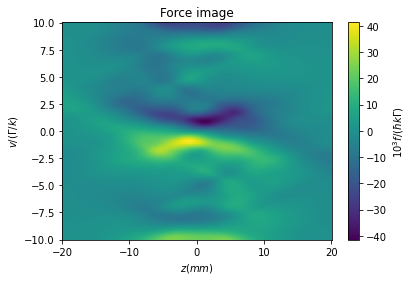

In [54]:
fig, ax = plt.subplots(1, 1)
plt.imshow(1e3*rateeq.profile['F'].F[2], origin='lower',
           extent=(np.amin(zz)-dz/2, np.amax(zz)-dz/2,
                   np.amin(vv)-dv/2, np.amax(vv)-dv/2),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$10^3f/(\hbar k \Gamma)$')
ax.set_xlabel('$z (mm)$')
ax.set_ylabel('$v/(\Gamma/k)$')
ax.set_title('Force image')
fig.subplots_adjust(left=0.12,right=0.9)

# fig.savefig('20210415_1.png')

In [55]:
def captured_condition(t, y, threshold=1e-5):
    if(y[-4]<threshold and y[-1]<1e-3):
        val = -1.
    else:
        val = 1.

    return val

def lost_condition(t, y, threshold=1e-5):
    if y[-1]>20 or y[-1]<-20.:
        val = -1.
    else:
        val = 1.

    return val

captured_condition.terminal=True
lost_condition.terminal=True

In [56]:
v0s = np.arange(1.,10.0,0.5)
t_eval = np.linspace(0.,200.,501)
sols_rate = list()

for v0a in v0s:
    rateeq.set_initial_position_and_velocity(np.array([0.,0.,-20]),np.array([0.,0.,v0a]))
    rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))
    
    rateeq.evolve_motion([0.,500.],t_eval=t_eval,max_step = 0.1,events = [captured_condition,lost_condition],progress_bar = 1)
    sols_rate.append(rateeq.sol)

Completed in 4.04 s.                                               
Completed in 2.65 s.                                               
Completed in 1.98 s.                                               
Completed in 1.58 s.                                               
Completed in 1.34 s.                                               
Completed in 1.15 s.                                               
Completed in 1.03 s.                                               
Completed in 0.90 s.                                                
Completed in 0.81 s.                                                
Completed in 0.75 s.                                               
Completed in 0.67 s.                                               
Completed in 0.62 s.                                               
Completed in 0.59 s.                                               
Completed in 0.54 s.                                               
Completed in 0.52 s.                          

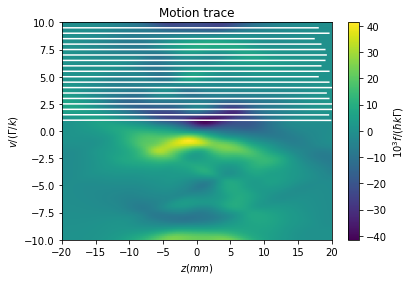

In [57]:
fig, ax = plt.subplots(1, 1)
plt.imshow(1e3*rateeq.profile['F'].F[2], origin='lower',
           extent=(np.amin(zz)-dz/2, np.amax(zz)-dz/2,
                   np.amin(vv)-dv/2, np.amax(vv)-dv/2),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$10^3f/(\hbar k \Gamma)$')
ax.set_xlabel('$z(mm)$')
ax.set_ylabel('$v/(\Gamma/k)$')
ax.set_title('Motion trace')
ax.set_xlim(-20,20)
ax.set_ylim(-10,10)
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_rate:
    ax.plot(sol.r[2],sol.v[2], 'w-')
    
# fig.savefig('20210423_3.png')

In [58]:
def is__it_trapped(v0,z0,eqn, captured_condition, lost_condition, tmax=1000, max_step=0.1, **kwargs):
    eqn.set_initial_position_and_velocity(np.array([0.,0.,z0]),np.array([0.,0.,v0]))
    if isinstance(eqn,pylcp.rateeq):
        eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))
    
    eqn.evolve_motion([0.,tmax],events = [captured_condition,lost_condition],max_step = max_step)
    
    if len(eqn.sol.t_events[0]) == 1:
        return 1
    else:
        return -1

In [60]:
from scipy.optimize import root_scalar
starttime = time.time()
vc = root_scalar(is__it_trapped,bracket=[0.01,1.],args = (-20,rateeq,captured_condition,lost_condition,5000,0.1),method = 'brentq')

print(time.time()-starttime)

4499.597084283829


In [61]:
vc.root*v0

0.25033325998146655

In [3]:
def vc_full_bayesian(Bgrad, w0, det1, det2, det3, det4, p1, p2, p3, p4, pol1, pol2, pol3, pol4):
    '''
    spits out capture velocity given the following MOT parameters:
    Bgrad: gradient in G/cm
    w0: 1/e^2 waist, in mm
    det1..4: detuning (units of Gamma) of beams 1-4. Detunings referenced to the four hyperfine levels, from low to high energy
    p1...4: fractional power of beams 1-4. These are normalized in the code, since the optimization will not constrain them to sum to 1
    pol1..4: polarization of beams 1-4. Runs from 0-1. Rounded in code so [0,0.5] is sigma-, [0.5,1] is sigma+
    '''
    
    laserpower = 200 #mW
    
    # Make the magnetic field (2 G/mm):
    magField = pylcp.quadrupoleMagneticField(Bgrad*0.1)
    
    # MOT parameters
    waist = w0*np.ones(4)*1e-3 #m, 1/e^2 waist
    detvec = np.array([det1, det2, det3, det4])
    Pvec = 1e-3*laserpower*np.array([p1, p2, p3, p4])/sum([p1,p2,p3,p4])
    intensities = 2.*Pvec/(np.pi*waist**2)/Isat
    polvec = 2*np.round(np.array([pol1, pol2, pol3, pol4]))-1
    
    laserBeams = six_beam_CaF_MOT(intensities, detvec, polvec, waist)
    trap = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)

    # See solve_ivp documentation for event function discussion:
    # y[-6:-1] is (vx, vy, vz, x, y, z)
    def captured_condition(t, y, threshold=1e-5):
        #if(y[-4]<threshold and y[-1]<1e-3):
#         vxy = np.sqrt(y[-6]**2 + y[-5]**2)
#         xy = np.sqrt(y[-3]**2 + y[-2]**2)
#         if (vxy<threshold and xy<1e-3):
        if (y[-6]<threshold and y[-3]<1e-3):
            val = -1.
        else:
            val = 1.

        return val

    def lost_condition(t, y, threshold=1e-5):
#         xy = np.sqrt(y[-3]**2 + y[-2]**2)
#         if xy>20:
        #if y[-1]>20.:
        if y[-3]>20.:
            val = -1.
        else:
            val = 1.

        return val

    captured_condition.terminal=True
    lost_condition.terminal=True

    init_pop = np.concatenate((1/12*np.ones(12),np.zeros(4))) #equal population in ground states, no population in excited states
    if isinstance(trap, pylcp.rateeq):
        trap.set_initial_pop(init_pop)
        
    z0 = -25. #initial position for capture trajectories, mm
        
    def iscaptured(v0, z0, eqn, captured_condition, lost_condition, tmax=1000, max_step=0.1, **kwargs):
#         eqn.set_initial_position_and_velocity(np.array([0., 0., z0]),
#                                               np.array([0., 0., v0]))
        eqn.set_initial_position_and_velocity(np.array([z0, 0., 0.]),
                                              np.array([v0, 0., 0.]))
        eqn.evolve_motion([0., tmax], events=[captured_condition, lost_condition],
                          max_step=max_step)

        if len(eqn.sol.t_events[0]) == 1:
            return +1.
        else:
            return -1.
        
#     print(iscaptured(1.,z0,trap,captured_condition,lost_condition))
    
    try: 
        vcout = bisect(iscaptured, 0.1, 5.,
           args=(z0, trap, captured_condition, lost_condition),
           xtol=0.25, rtol=1e-4, full_output=False
          )
    except ValueError:
        print('ValueError encountered, assuming capture velocity is zero')
        vcout = 0.
    
    return vcout

In [4]:
vc_full_bayesian(19.1,5.3,-2.1,-1.9,-7.1,-1.2,0.226,0.333,0.133,0.308,0.,1.,1.,0.)

2.3968750000000005

In [5]:
vc_full_bayesian(19.1,5.3,-2.1,-1.9,-7.1,-1.2,0.226,0.333,0.133,0.308,0.,1.,1.,0.) #along x axis

2.3968750000000005

In [6]:
vc_full_bayesian(19.1,5.3,-2.1,-1.9,-7.1,-1.2,0.226,0.333,0.133,0.308,0.,1.,1.,0.) #along x-y direction

2.3968750000000005

In [7]:
vc_full_bayesian(20,8,-1,-1,-1,-1,0.25,0.25,0.25,0.25,1.,1.,1.,0.)

1.784375

## Running the optimization - for motion along x

In [8]:
from bayes_opt import BayesianOptimization

In [9]:
# Bounded region of parameter space
detmin = -10.
detmax = 10.
pbounds = {'Bgrad': (5., 30.), 'w0': (4., 15.), 'det1': (detmin, detmax), 'det2': (detmin, detmax), 'det3': (detmin, detmax), 'det4': (detmin, detmax),
              'p1': (0., 1.), 'p2': (0., 1.), 'p3': (0., 1.), 'p4': (0., 1.), 'pol1': (0., 1.), 'pol2': (0., 1.), 'pol3': (0., 1.), 'pol4': (0., 1.)}

optimizer = BayesianOptimization(
    f=vc_full_bayesian,
    pbounds=pbounds,
    random_state=1,
)

In [10]:
optimizer.maximize(
    init_points=30,
    n_iter=100,
)

|   iter    |  target   |   Bgrad   |   det1    |   det2    |   det3    |   det4    |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    w0     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.2531   |  15.43    |  4.406    | -9.998    | -3.953    | -7.065    |  0.09234  |  0.1863   |  0.3456   |  0.3968   |  0.5388   |  0.4192   |  0.6852   |  0.2045   |  13.66    |
ValueError encountered, assuming capture velocity is zero
|  2        |  0.0      |  5.685    |  3.409    | -1.654    |  1.174    | -7.192    |  0.1981   |  0.8007   |  0.9683   |  0.3134   |  0.6923   |  0.8764   |  0.8946   |  0.08504  |  4.43     |
ValueError encountered, assuming capture velocity is zero
|  3        |  0.0      |  9.246    |  7.563    | -8.033    | -1.578    |  9.158    |  0.5332   |  0.6919   

In [11]:
optimizer.maximize(
    init_points=30,
    n_iter=100,
)

|   iter    |  target   |   Bgrad   |   det1    |   det2    |   det3    |   det4    |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    w0     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
ValueError encountered, assuming capture velocity is zero
|  131      |  0.0      |  8.586    | -8.432    | -9.633    | -8.666    | -0.8283   |  0.1133   |  0.02778  |  0.7549   |  0.3949   |  0.7469   |  0.4524   |  0.4501   |  0.4781   |  9.214    |
ValueError encountered, assuming capture velocity is zero
|  132      |  0.0      |  25.08    | -1.952    |  8.094    | -9.259    |  5.477    |  0.1256   |  0.6185   |  0.01036  |  0.5386   |  0.003018 |  0.9512   |  0.9054   |  0.796    |  14.07    |
|  133      |  0.2531   |  8.639    | -6.845    | -6.247    |  2.45     |  8.116    |  0.99     |  0.7111   

In [12]:
optimizer.maximize(
    init_points=30,
    n_iter=100,
)

|   iter    |  target   |   Bgrad   |   det1    |   det2    |   det3    |   det4    |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    w0     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
ValueError encountered, assuming capture velocity is zero
|  261      |  0.0      |  9.038    | -3.151    | -4.762    |  6.891    |  6.007    |  0.4266   |  0.607    |  0.1455   |  0.5096   |  0.2969   |  0.8597   |  0.6716   |  0.6335   |  5.372    |
ValueError encountered, assuming capture velocity is zero
|  262      |  0.0      |  16.76    |  9.731    |  8.966    |  2.902    | -6.966    |  0.6391   |  0.5657   |  0.4687   |  0.428    |  0.5993   |  0.85     |  0.7511   |  0.5794   |  14.17    |
ValueError encountered, assuming capture velocity is zero
|  263      |  0.0      |  6.618    |  9.827    | 

In [13]:
optimizer.maximize(
    init_points=50,
    n_iter=100,
)

|   iter    |  target   |   Bgrad   |   det1    |   det2    |   det3    |   det4    |    p1     |    p2     |    p3     |    p4     |   pol1    |   pol2    |   pol3    |   pol4    |    w0     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
ValueError encountered, assuming capture velocity is zero
|  391      |  0.0      |  7.955    |  6.74     |  4.883    |  1.81     | -5.142    |  0.6232   |  0.6384   |  0.3276   |  0.06749  |  0.8805   |  0.46     |  0.7639   |  0.2539   |  10.51    |
|  392      |  0.5594   |  15.72    | -2.358    | -7.466    | -5.115    | -8.413    |  0.3029   |  0.7417   |  0.615    |  0.6724   |  0.008383 |  0.6784   |  0.5032   |  0.2309   |  5.924    |
|  393      |  0.2531   |  9.625    |  6.885    |  9.652    |  8.275    | -3.053    |  0.7802   |  0.5465   |  0.8164   |  0.4837   |  0.59     |  0.7873   |  0.1002 

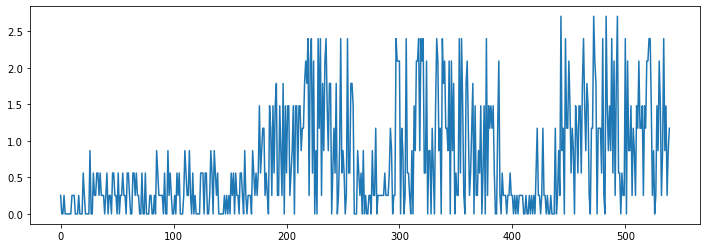

In [14]:
targets_x = np.zeros(len(optimizer.res))
for i, res in enumerate(optimizer.res):
    targets_x[i] = res['target']
    
fig1, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(targets_x)

In [15]:
maxtarget_x = np.amax(targets_x)
print(maxtarget_x)
maxinds_x = np.where(targets_x == maxtarget_x)
print(maxinds_x)

2.7031250000000004
(array([443, 472, 483, 493], dtype=int64),)


In [16]:
for i in maxinds_x[0]:
    print("Iteration {}: \n\t{}".format(i, optimizer.res[i]))

Iteration 443: 
	{'target': 2.7031250000000004, 'params': {'Bgrad': 18.44243699197725, 'det1': -1.8878078834680583, 'det2': 8.984648606232518, 'det3': -4.508483768546374, 'det4': 6.278636523676795, 'p1': 0.6014058941043637, 'p2': 0.5438134881043205, 'p3': 0.4542122177153384, 'p4': 0.5931093372033646, 'pol1': 0.2663572086024121, 'pol2': 0.9221642422511719, 'pol3': 0.15308647653809138, 'pol4': 0.8407927096593375, 'w0': 4.0455808972340215}}
Iteration 472: 
	{'target': 2.7031250000000004, 'params': {'Bgrad': 18.487173142519723, 'det1': -1.45696600907344, 'det2': 8.634382087069984, 'det3': -4.2181760222256655, 'det4': 6.287671115105881, 'p1': 0.5948135800485098, 'p2': 0.5086818702363811, 'p3': 0.4517155801999827, 'p4': 0.5935031518332621, 'pol1': 0.3395587711184538, 'pol2': 0.8036866379621851, 'pol3': 0.34847921025455814, 'pol4': 0.7220624912426352, 'w0': 4.301601537098535}}
Iteration 483: 
	{'target': 2.7031250000000004, 'params': {'Bgrad': 18.243609474257998, 'det1': -1.6220426230467315, 

## Plotting force profiles

In [17]:
def plot_force_profiles(Bgrad, w0, det1, det2, det3, det4, p1, p2, p3, p4, pol1, pol2, pol3, pol4):
    '''
    plots force profiles given the following MOT parameters:
    Bgrad: gradient in G/cm
    w0: 1/e^2 waist, in mm
    det1..4: detuning (units of Gamma) of beams 1-4. Detunings referenced to the four hyperfine levels, from low to high energy
    p1...4: fractional power of beams 1-4. These are normalized in the code, since the optimization will not constrain them to sum to 1
    pol1..4: polarization of beams 1-4. Runs from 0-1. Rounded in code so [0,0.5] is sigma-, [0.5,1] is sigma+
    '''
    
    laserpower = 200 #mW
    
    # Make the magnetic field (2 G/mm):
    magField = pylcp.quadrupoleMagneticField(Bgrad*0.1)
    
    # MOT parameters
    waist = w0*np.ones(4)*1e-3 #m, 1/e^2 waist
    detvec = np.array([det1, det2, det3, det4])
    Pvec = 1e-3*laserpower*np.array([p1, p2, p3, p4])/sum([p1,p2,p3,p4])
    intensities = 2.*Pvec/(np.pi*waist**2)/Isat
    polvec = 2*np.round(np.array([pol1, pol2, pol3, pol4]))-1
    
    laserBeams = six_beam_CaF_MOT(intensities, detvec, polvec, waist)
    trap = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)
    
    # Make the axis:
    z = np.linspace(1e-10, 20., 101)
    v = np.linspace(0., 6., 101)
    
    trap.generate_force_profile(
        [np.zeros(z.shape), np.zeros(z.shape), z],
        [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
        name='Fz')
    trap.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), 1e-9*np.ones(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='Fv')
    
    fig, ax = plt.subplots(1, 2, figsize=(11.5, 4), num="Forces in CaF MOT")
    ax[0].plot(z, 1e9*4*np.pi**2*cts.hbar*k*Gamma/(59*cts.u)*trap.profile['Fz'].F[2], color='C{0:d}'.format(0))
    ax[1].plot(v*Gamma/k, 1e9*4*np.pi**2*cts.hbar*k*Gamma/(59*cts.u)*trap.profile['Fv'].F[2], color='C{0:d}'.format(0))
    
    ## now plot force profiles along x axis
    trap.generate_force_profile(
        [z, np.zeros(z.shape), np.zeros(z.shape)],
        [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
        name='Fx')
    trap.generate_force_profile(
        [1e-9*np.ones(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [v, np.zeros(v.shape), np.zeros(v.shape)],
        name='Fvx')
    trap.generate_force_profile(
        [1e-9*np.ones(v.shape), 1e-9*np.ones(v.shape), np.zeros(v.shape)],
        [v/np.sqrt(2), v/np.sqrt(2), np.zeros(v.shape)],
        name='Fvxy')
    
    ax[0].plot(z, 1e9*4*np.pi**2*cts.hbar*k*Gamma/(59*cts.u)*trap.profile['Fx'].F[0], color='C{0:d}'.format(1))
    ax[1].plot(v*Gamma/k, 1e9*4*np.pi**2*cts.hbar*k*Gamma/(59*cts.u)*trap.profile['Fvx'].F[0], color='C{0:d}'.format(1))
    ax[1].plot(v*Gamma/k, 1e9*4*np.pi**2*cts.hbar*k*Gamma/(59*cts.u)*(trap.profile['Fvxy'].F[0]+trap.profile['Fvxy'].F[1])/np.sqrt(2), color='C{0:d}'.format(2))
    
#     print(trap.profile['Fxy'].F[0])

    ##some ill-fated diagnostics. Seems there are some serious issues with calculating forces off-axis...
    
#     trap.generate_force_profile(
#         [0.1, 0.1, 0.],
#         [0., 0., 0.],
#         name='Ftest')
    
#     print(trap.profile['Ftest'].F[0])
#     print(trap.r0)
#     print(trap.magField.Field(trap.r0))
#     Bmag = np.linalg.norm(trap.magField.Field(trap.r0),axis=0)
#     print(Bmag)
#     print(trap.hamiltonian.diag_static_field(Bmag))
#     print(trap.hamiltonian.n)
#     print(trap.equilibrium_populations(trap.r0,trap.v0,t=0.,return_details=False))
#     print(trap.construct_evolution_matrix(trap.r0,trap.v0,t=0.))
    
    ############
    
    for ax_i in ax:
        ax_i.set_ylabel('Acceleration ($10^3$ m/s$^2$)')
    
    ax[0].set_xlabel('$z$ (mm)')
    ax[1].set_xlabel('$v$ (m/s)')
    
    fig.subplots_adjust(hspace=0.33, wspace=0.2)

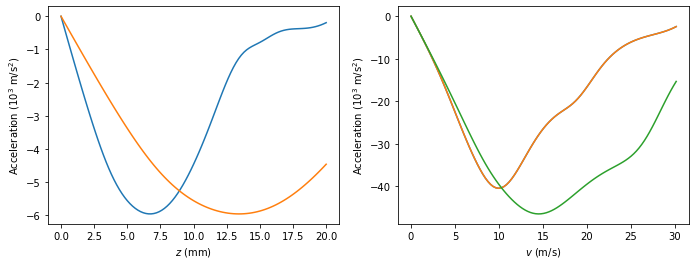

In [18]:
plot_force_profiles(19.1,5.3,-2.1,-1.9,-7.1,-1.2,0.226,0.333,0.133,0.308,0.,1.,1.,0.)

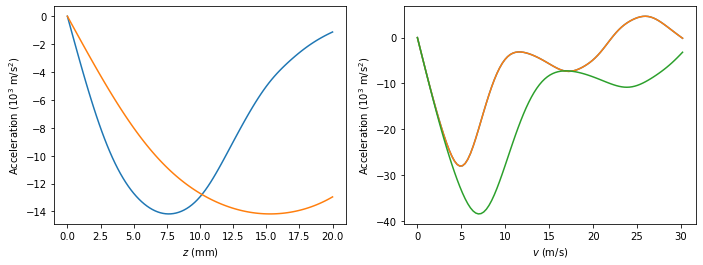

In [19]:
plot_force_profiles(20,8,-1,-1,-1,-1,0.25,0.25,0.25,0.25,1.,1.,1.,0.)

In [20]:
def plot_trajectories(Bgrad, w0, det1, det2, det3, det4, p1, p2, p3, p4, pol1, pol2, pol3, pol4):
    '''
    plots force profiles given the following MOT parameters:
    Bgrad: gradient in G/cm
    w0: 1/e^2 waist, in mm
    det1..4: detuning (units of Gamma) of beams 1-4. Detunings referenced to the four hyperfine levels, from low to high energy
    p1...4: fractional power of beams 1-4. These are normalized in the code, since the optimization will not constrain them to sum to 1
    pol1..4: polarization of beams 1-4. Runs from 0-1. Rounded in code so [0,0.5] is sigma-, [0.5,1] is sigma+
    '''
    
    laserpower = 200 #mW
    
    # Make the magnetic field (2 G/mm):
    magField = pylcp.quadrupoleMagneticField(Bgrad*0.1)
    
    # MOT parameters
    waist = w0*np.ones(4)*1e-3 #m, 1/e^2 waist
    detvec = np.array([det1, det2, det3, det4])
    Pvec = 1e-3*laserpower*np.array([p1, p2, p3, p4])/sum([p1,p2,p3,p4])
    intensities = 2.*Pvec/(np.pi*waist**2)/Isat
    polvec = 2*np.round(np.array([pol1, pol2, pol3, pol4]))-1
    
    laserBeams = six_beam_CaF_MOT(intensities, detvec, polvec, waist)
    trap = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)
    
    #calculating z-v phase space
    ep = 0.1
    dz = 0.5
    dv = 0.1
    z = np.arange(-20+ep, 20+dz+ep, dz)
    v = np.arange(-5, 5+dv, dv)

    Z, V = np.meshgrid(z, v)

    Rfull = np.array([np.zeros(Z.shape), np.zeros(Z.shape), Z])
    Vfull = np.array([np.zeros(Z.shape), np.zeros(Z.shape), V])

    trap.generate_force_profile([np.zeros(Z.shape), np.zeros(Z.shape), Z],
                               [np.zeros(V.shape), np.zeros(V.shape), V],
                               name='Fz', progress_bar=True);
    
    z0 = -20 #initial position for capture trajectories, mm
    v0s = np.arange(0.25, 3, 0.25)

    # See solve_ivp documentation for event function discussion:
    # y[-6:-1] is (vx, vy, vz, x, y, z)
    def captured_condition(t, y, threshold=1e-5):
        if(y[-4]<threshold and y[-1]<1e-3):
            val = -1.
        else:
            val = 1.

        return val

    def lost_condition(t, y, threshold=1e-5):
        if y[-1]>20.:
            val = -1.
        else:
            val = 1.

        return val

    captured_condition.terminal=True
    lost_condition.terminal=True

    init_pop = np.concatenate((1/12*np.ones(12),np.zeros(4))) #equal population in ground states, no population in excited states
    sols = []
    for v0 in v0s:
        trap.set_initial_position_and_velocity(np.array([0., 0., z0]),
                                              np.array([0., 0., v0]))
        if isinstance(trap, pylcp.rateeq):
            trap.set_initial_pop(init_pop)

        trap.evolve_motion([0., 100.], events=[captured_condition, lost_condition], max_step=0.1, progress_bar = True)

        sols.append(trap.sol)
        
    fig, ax = plt.subplots(1, 1)
    plt.imshow(trap.profile['Fz'].F[2], origin='lower',
               extent=(np.amin(z)-dz/2, np.amax(z)-dz/2,
                       np.amin(v)-dv/2, np.amax(v)-dv/2),
               aspect='auto')
    cb1 = plt.colorbar()
    cb1.set_label('$f/(\hbar k \Gamma)$')
    ax.set_xlabel('$z$ (mm)')
    ax.set_ylabel('$v/(\Gamma/k)$')

    fig.subplots_adjust(left=0.15, right=0.91, bottom=0.2)

    for sol in sols:
        ax.plot(sol.r[2], sol.v[2], 'w-', linewidth=0.375)

    #ax.yaxis.set_ticks([-5, 0, 5])
    # Display the figure at the end of the thing.
    ax.set_xlim((-20, 20))
    ax.set_xlim((-20, 20));

Completed in 12.49 s.                                               
Completed in 7.40 s.                                               
Completed in 6.82 s.                                               
Completed in 6.52 s.                                               
Completed in 6.51 s.                                               
Completed in 6.71 s.                                               
Completed in 5.19 s.                                               
Completed in 2.50 s.                                               
Completed in 1.96 s.                                               
Completed in 1.67 s.                                               
Completed in 1.47 s.                                               
Completed in 1.35 s.                                               


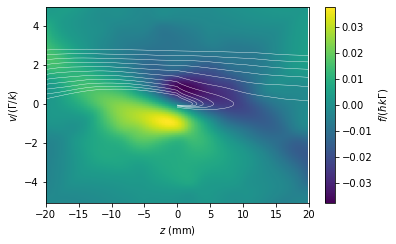

In [21]:
plot_trajectories(20,8,-1,-1,-1,-1,0.25,0.25,0.25,0.25,1.,1.,1.,0.)

Completed in 12.52 s.                                               
Completed in 8.72 s.                                               
Completed in 8.70 s.                                               
Completed in 8.72 s.                                               
Completed in 8.73 s.                                               
Completed in 8.72 s.                                               
Completed in 8.73 s.                                               
Completed in 5.99 s.                                               
Completed in 3.51 s.                                               
Completed in 2.60 s.                                               
Completed in 2.08 s.                                               
Completed in 1.74 s.                                               


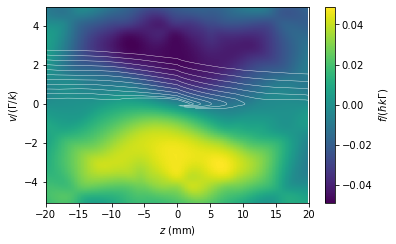

In [22]:
plot_trajectories(19.1,5.3,-2.1,-1.9,-7.1,-1.2,0.226,0.333,0.133,0.308,0.,1.,1.,0.)

In [23]:
Gamma/k

5.029800000000001

In [24]:
np.sqrt(2)

1.4142135623730951

In [25]:
def plot_trajectories_xy(Bgrad, w0, det1, det2, det3, det4, p1, p2, p3, p4, pol1, pol2, pol3, pol4):
    '''
    plots force profiles given the following MOT parameters:
    Bgrad: gradient in G/cm
    w0: 1/e^2 waist, in mm
    det1..4: detuning (units of Gamma) of beams 1-4. Detunings referenced to the four hyperfine levels, from low to high energy
    p1...4: fractional power of beams 1-4. These are normalized in the code, since the optimization will not constrain them to sum to 1
    pol1..4: polarization of beams 1-4. Runs from 0-1. Rounded in code so [0,0.5] is sigma-, [0.5,1] is sigma+
    '''
    
    laserpower = 200 #mW
    
    # Make the magnetic field (2 G/mm):
    magField = pylcp.quadrupoleMagneticField(Bgrad*0.1)
    
    # MOT parameters
    waist = w0*np.ones(4)*1e-3 #m, 1/e^2 waist
    detvec = np.array([det1, det2, det3, det4])
    Pvec = 1e-3*laserpower*np.array([p1, p2, p3, p4])/sum([p1,p2,p3,p4])
    intensities = 2.*Pvec/(np.pi*waist**2)/Isat
    polvec = 2*np.round(np.array([pol1, pol2, pol3, pol4]))-1
    
    laserBeams = six_beam_CaF_MOT(intensities, detvec, polvec, waist)
    trap = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)
    
    #calculating x-v phase space
    ep = 0.1
    dz = 0.5
    dv = 0.1
    z = np.arange(-20+ep, 20+dz+ep, dz)
    v = np.arange(-5, 5+dv, dv)

    Z, V = np.meshgrid(z, v)

    Rfull = np.array([Z, np.zeros(Z.shape), np.zeros(Z.shape)])
    Vfull = np.array([V, np.zeros(Z.shape), np.zeros(Z.shape)])

    trap.generate_force_profile([Z, np.zeros(Z.shape), np.zeros(Z.shape)],
                               [V, np.zeros(V.shape), np.zeros(V.shape)],
                               name='Fx', progress_bar=True);
    
    z0 = -20 #initial position for capture trajectories, mm
    v0s = np.arange(0.25, 3, 0.25)

    # See solve_ivp documentation for event function discussion:
    # y[-6:-1] is (vx, vy, vz, x, y, z)
    def captured_condition(t, y, threshold=1e-5):
        #if(y[-4]<threshold and y[-1]<1e-3):
        vxy = np.sqrt(y[-6]**2 + y[-5]**2)
        xy = np.sqrt(y[-3]**2 + y[-2]**2)
        if (vxy<threshold and xy<1e-3):
            val = -1.
        else:
            val = 1.

        return val

    def lost_condition(t, y, threshold=1e-5):
        xy = np.sqrt(y[-3]**2 + y[-2]**2)
        if xy>20:
        #if y[-1]>20.:
            val = -1.
        else:
            val = 1.

        return val

    captured_condition.terminal=True
    lost_condition.terminal=True

    init_pop = np.concatenate((1/12*np.ones(12),np.zeros(4))) #equal population in ground states, no population in excited states
    sols = []
    for v0 in v0s:
        trap.set_initial_position_and_velocity(np.array([z0, z0, 0.]),
                                              np.array([v0/np.sqrt(2), v0/np.sqrt(2), 0.]))
        if isinstance(trap, pylcp.rateeq):
            trap.set_initial_pop(init_pop)

        trap.evolve_motion([0., 100.], events=[captured_condition, lost_condition], max_step=0.1, progress_bar = True)

        sols.append(trap.sol)
        
    fig, ax = plt.subplots(1, 1)
    plt.imshow(trap.profile['Fx'].F[0], origin='lower',
               extent=(np.amin(z)-dz/2, np.amax(z)-dz/2,
                       np.amin(v)-dv/2, np.amax(v)-dv/2),
               aspect='auto')
    cb1 = plt.colorbar()
    cb1.set_label('$f/(\hbar k \Gamma)$')
    ax.set_xlabel('$x$ (mm)')
    ax.set_ylabel('$v/(\Gamma/k)$')

    fig.subplots_adjust(left=0.15, right=0.91, bottom=0.2)

    for sol in sols:
        ax.plot(sol.r[0], sol.v[0], 'w-', linewidth=0.375)
        ax.plot(sol.r[1], sol.v[1], 'r-', linewidth=0.375)

    #ax.yaxis.set_ticks([-5, 0, 5])
    # Display the figure at the end of the thing.
    ax.set_xlim((-20, 20))
    ax.set_xlim((-20, 20));

Completed in 12.42 s.                                               
Completed in 2.92 s.                                               
Completed in 1.48 s.                                               
Completed in 0.99 s.                                              
Completed in 0.75 s.                                              
Completed in 0.62 s.                                              
Completed in 0.52 s.                                              
Completed in 0.45 s.                                              
Completed in 0.39 s.                                              
Completed in 0.36 s.                                              
Completed in 0.32 s.                                              
Completed in 0.30 s.                                              


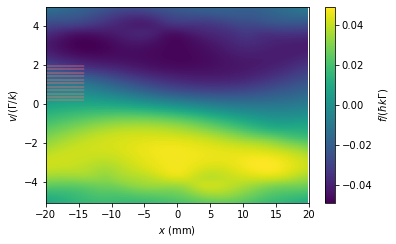

In [26]:
plot_trajectories_xy(19.1,5.3,-2.1,-1.9,-7.1,-1.2,0.226,0.333,0.133,0.308,0.,1.,1.,0.)

Completed in 12.57 s.                                               
Completed in 2.93 s.                                               
Completed in 1.48 s.                                               
Completed in 1.00 s.                                              
Completed in 0.75 s.                                              
Completed in 0.61 s.                                              
Completed in 0.51 s.                                              
Completed in 0.45 s.                                              
Completed in 0.42 s.                                              
Completed in 0.35 s.                                              
Completed in 0.33 s.                                              
Completed in 0.29 s.                                              


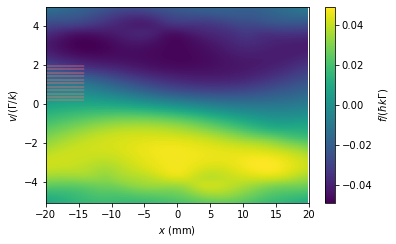

In [27]:
plot_trajectories_xy(19.1,5.3,-2.1,-1.9,-7.1,-1.2,0.226,0.333,0.133,0.308,0.,1.,1.,0.)

In [28]:
print(time.time()-start)

30720.058638334274
